# Demo of training a rather simple model
We hope this jupyter notebook is helpful in understanding the data. It is by no means a suggestion to train your model. 

**Author**: `Shu Kong <shuk@andrew.cmu.edu>`

**Date**: May 2020

## import packages

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [1]:
from __future__ import print_function, division
import random, time, copy, scipy, pickle, sys, math, gzip, html, os, ftfy, torch
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc, ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

from functools import lru_cache
import pandas as pd
import seaborn as sn
import sklearn.metrics 
import regex as re

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.dataset_OWV import *
from utils.network_arch import *
from utils.trainval import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")


print(sys.version)
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
1.7.1
True
9.2


## set up environment
 

In [2]:
# set the random seed
torch.manual_seed(0)

################## setup for this project/experiment ##################
# config experiment directory used for reading the init model
exp_dir = './exp' 

project_name = 'dummy_model'

# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'

nClassTotal = 414 # total number of classes
isPretrained = False # DO NOT USE IMAGENET PRETRAINING!!
encoder_num_layers = 18 # use a rather simple network, ResNet18

batch_size = 64 
total_epoch_num = 90 # total number of epochs in training
base_lr = 0.001 # base learning rate

torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

# randomly initialize the model
clsModel = ResnetEncoder(encoder_num_layers, isPretrained, embDimension=nClassTotal, poolSize=7)

./exp/dummy_model


## set up dataset

### training data

/scratch/shuk/dataset/dataset-open-world-vision-challenge/train/known_classes/00040/.00371.JPEG.jbEUUs
/scratch/shuk/dataset/dataset-open-world-vision-challenge/train/known_classes/00349/.00051.JPEG.2aPqAY
/scratch/shuk/dataset/dataset-open-world-vision-challenge/train/known_classes/00037/.00407.JPEG.nVZrb4
/scratch/shuk/dataset/dataset-open-world-vision-challenge/train/known_classes/00334/.00202.JPEG.S6Kndu
/scratch/shuk/dataset/dataset-open-world-vision-challenge/train/known_classes/00407/.00233.JPEG.Z9Bno3
/scratch/shuk/dataset/dataset-open-world-vision-challenge/train/known_classes/00130/.00290.JPEG.p0SYfS
/scratch/shuk/dataset/dataset-open-world-vision-challenge/train/known_classes/00130/.00312.JPEG.4un3MM
/scratch/shuk/dataset/dataset-open-world-vision-challenge/train/known_classes/00343/.00261.JPEG.kl27Jy
484416
smallest class:  335.0
largest class:  6959.0


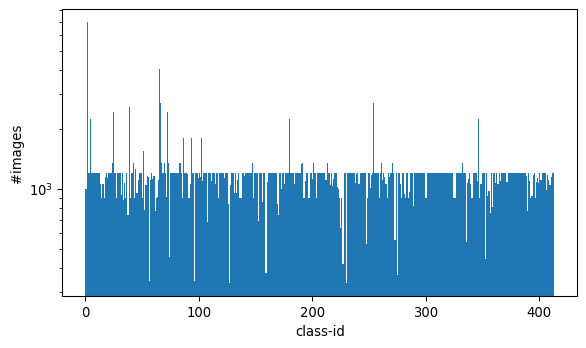

In [3]:
datasets = {}
dataloaders = {}

# where is the dataset?
path_to_data='/scratch/shuk/dataset/dataset-open-world-vision-challenge'
set_name = 'train'

imageList=[]
labelList=[]
tmp_path = path.join(path_to_data, set_name, 'known_classes')            
for curclass in os.listdir(tmp_path):
    imglist = os.listdir(os.path.join(tmp_path, curclass))
    for curimgname in imglist:
        if len(curimgname)>5:
            path_to_img = os.path.join(tmp_path, curclass, curimgname)
            a = path_to_img.split('/')
            if a[-1][0]=='.':
                print(path_to_img)
            else:
                imageList.append(path_to_img)
                labelList.append(float(curclass))


valset_filename = 'train_novel_images_gt.csv'
with open(path.join(path_to_data, 'labels', valset_filename)) as fn:
    for line in fn:
        tmp = line.strip().split(',')
        if 'train' in tmp[0]:
            path_to_img = path_to_img.replace('images/', '')
            a = path_to_img.split('/')
            if a[-1][0]=='.':
                print(path_to_img)
            else:
                imageList.append(path_to_img)
                labelList.append(float(tmp[1]))

datasets[set_name] = OWV_dataset(set_name=set_name, imageList=imageList, labelList=labelList, isAugment=set_name=='train')
print(len(datasets[set_name]))


# histogram
fig = plt.figure(figsize=(7,4), dpi=95) 
counts = plt.hist(labelList, nClassTotal)
plt.yscale('log')
plt.xlabel('class-id')
plt.ylabel('#images');

print('smallest class: ', counts[0].min())
print('largest class: ', counts[0].max())

### validation data

2000
smallest class:  2.0
largest class:  250.0


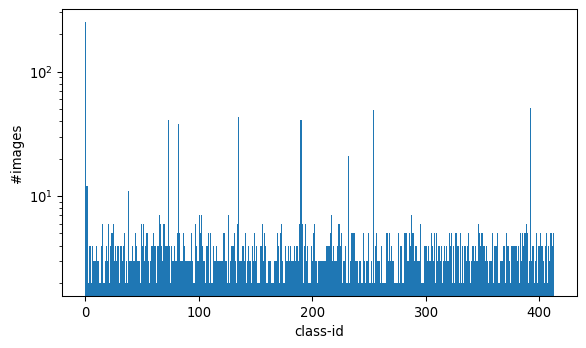

In [4]:
imageList=[]
labelList=[]

path_to_data='/scratch/shuk/dataset/dataset-open-world-vision-challenge'
set_name = 'val'
valset_filename = 'eval_0.5_2.csv'

with open(path.join(path_to_data, 'labels', valset_filename)) as fn:
    for line in fn:
        tmp = line.strip().split(',')
        if 'val' in tmp[0]:
            imageList.append(path.join(path_to_data, tmp[0]))
            labelList.append(float(tmp[1]))
            
datasets[set_name] = OWV_dataset(set_name=set_name, imageList=imageList, labelList=labelList, isAugment=set_name=='train')
print(len(datasets[set_name]))



# histogram
fig = plt.figure(figsize=(7,4), dpi=95) 
counts = plt.hist(labelList, nClassTotal)
plt.yscale('log')
plt.xlabel('class-id')
plt.ylabel('#images');

print('smallest class: ', counts[0].min())
print('largest class: ', counts[0].max())

### data loader

In [5]:
dataloaders = {set_name: DataLoader(datasets[set_name],
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'val']} # 'train',

print(len(dataloaders['train']), len(dataloaders['val']))

7569 32


### visualization to double check data loader

torch.Size([64, 3, 224, 224])


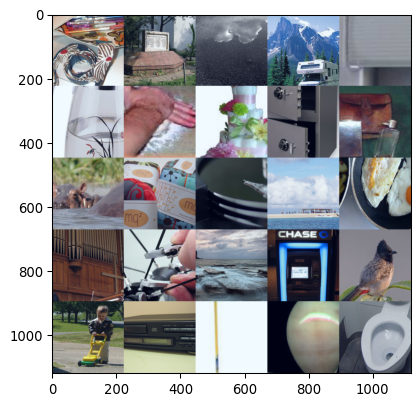

In [6]:
data_sampler = iter(dataloaders['train'])
data = next(data_sampler)
imageList224, labelList = data

imageList224 = imageList224.to(device)
labelList = labelList.type(torch.long).view(-1).to(device)

print(imageList224.shape)

imList = imageList224.permute(0,2,3,1).cpu().numpy()
imList -= imList.min()
imList /= imList.max()+0.0001
imList = createMontage(imList, (224, 224, 25))

fig = plt.figure(figsize=(5,5), dpi=95) # better display with larger figure
plt.imshow(imList)

torch.Size([64, 3, 224, 224])


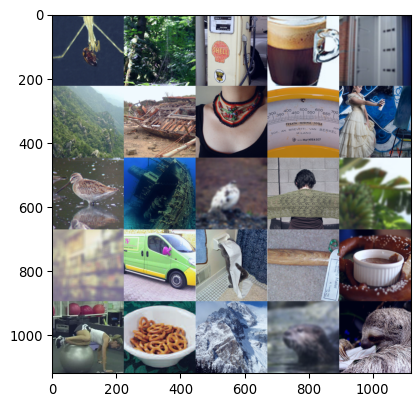

In [7]:
data_sampler = iter(dataloaders['val'])
data = next(data_sampler)
imageList224, labelList = data

imageList224 = imageList224.to(device)
labelList = labelList.type(torch.long).view(-1).to(device)

print(imageList224.shape)

imList = imageList224.permute(0,2,3,1).cpu().numpy()
imList -= imList.min()
imList /= imList.max()+0.0001
imList = createMontage(imList, (224, 224, 25))

fig = plt.figure(figsize=(5,5), dpi=95) # better display with larger figure
plt.imshow(imList)

## training demo


### loss function and optimizer

In [8]:
################## loss function ###################
loss_CrossEntropy = nn.CrossEntropyLoss()

# use Adam optimizer
optimizer = optim.Adam([{'params': clsModel.parameters(), 'lr': base_lr}], lr=base_lr)

# Decay LR by a factor of 0.1 every int(total_epoch_num/3) epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=int(total_epoch_num/3), gamma=0.1)

In [ ]:
################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

clsModel.to(device)
flagSuccess = train_model(
    dataloaders, clsModel, loss_CrossEntropy, 
    optimizer, exp_lr_scheduler, num_epochs=total_epoch_num, work_dir=save_dir, device=device, freqShow=200)


Epoch 1/90
----------
train
	200/7569 loss:5.987, loss_CE:5.987, acc-full:0.01445
	400/7569 loss:5.835, loss_CE:5.835, acc-full:0.01738
